In [24]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sma

import seaborn as sns
import Quandl

from __future__ import division, print_function

sns.set(style="whitegrid", color_codes=True)
plt.style.use('seaborn-whitegrid')

%matplotlib inline

Some exploration of stock market data based Chapter 3 in http://python-for-finance.com/ by Yves Hilpish.

I've added a couple of (small) new things, for example using Quandl as the data source and the ability to more easily vary the time range for the moving averages used in the trading strategy.

### Get Data from Quandl
We'll get daily for the S&P500 from Quandl

In [25]:
sp500 = Quandl.get("YAHOO/INDEX_GSPC", authtoken="6eVZpvq3zGzGsbaNsdDN", 
    trim_start='1990-01-01', trim_end='2016-01-31')                   

In [26]:
sp500.describe()

,Open,High,Low,Close,Volume,Adj Close
count,6572.000000,6572.000000,6572.000000,6572.000000,6.572000e+03,6572.000000
mean,1071.865132,1078.610138,1064.666690,1072.099747,1.974885e+09,1072.099747
std,462.587794,464.942856,459.999170,462.579934,1.774818e+09,462.579934
min,295.450012,301.450012,294.510010,295.459991,1.499000e+07,295.459991
25%,662.099976,664.922516,659.105011,662.235016,4.153125e+08,662.235016
50%,1126.455017,1133.875000,1119.750000,1126.450012,1.360200e+09,1126.450012
75%,1353.300018,1362.749969,1342.182495,1353.397522,3.344888e+09,1353.397522
max,2130.360107,2134.719971,2126.060059,2130.820068,1.145623e+10,2130.820068


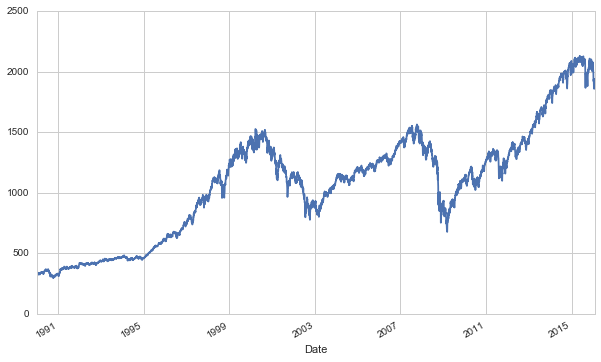

In [27]:
close_col = 'Adj Close'
sp500[close_col].plot(figsize=(10,6))

### Calculate Returns
We'll calculate (logged) returns for the market

In [28]:
sp500['Market'] = np.log(sp500[close_col]/sp500[close_col].shift(1))

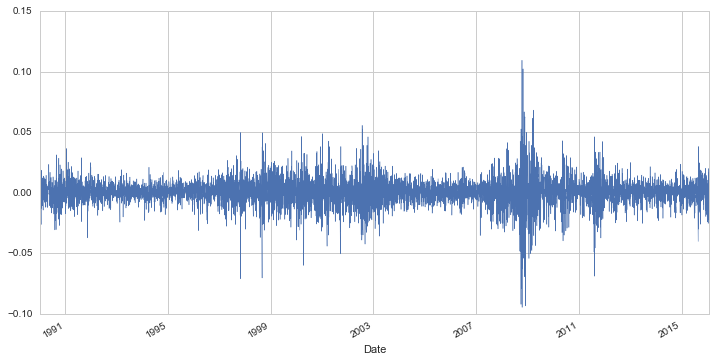

In [29]:
sp500['Market'].plot(figsize=(12,6), lw=.5)

The distribution plot (histogram) for the market returns shows a Laplace distribution

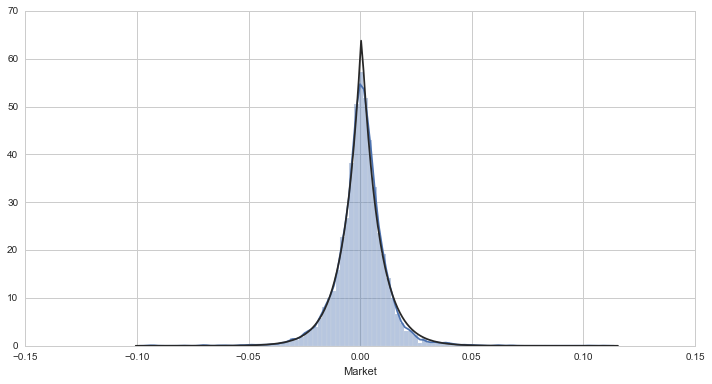

In [30]:
plt.figure(figsize=(12,6))
sns.distplot(sp500['Market'].dropna(), bins=100, kde=True, fit=sp.stats.laplace)
plt.show()

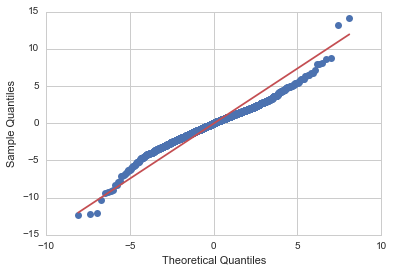

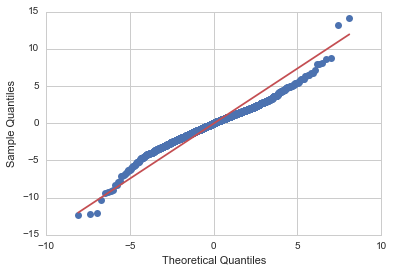

In [31]:
import statsmodels.api as sm
sm.qqplot(sp500['Market'].dropna().as_matrix(), dist=sp.stats.distributions.laplace, fit=True, line='s')

Normality tests show the distribution of log returns is not normally distributed in this dataset:

In [32]:
def dist_stats(arr):
    print ('Skew\t\t %14.3f' % sp.stats.skew(arr))
    print ('Skew p\t\t %14.3f' % sp.stats.skewtest(arr)[1])
    print ('Kurtosis\t %14.3f' % sp.stats.kurtosis(arr))
    print ('Kurtosis p\t %14.3f' % sp.stats.kurtosistest(arr)[1])
    print ('Normal p\t %14.3f' % sp.stats.normaltest(arr)[1])
    print ('\n')

arr = sp500['Market'].dropna().as_matrix()
dist_stats(arr)

print ('Compare to normal distribution:')
dist_stats(np.random.normal(0, 1, 1000000))

Skew		         -0.239
Skew p		          0.000
Kurtosis	          8.581
Kurtosis p	          0.000
Normal p	          0.000


Compare to normal distribution:
Skew		          0.004
Skew p		          0.117
Kurtosis	         -0.001
Kurtosis p	          0.829
Normal p	          0.286




## Trend Strategy Test
To determine which market regime we are in, we'll take the difference of the two MAs and using an arbitrary threshold, we'll determine whether the market regime is positive, neutral or negative

### Calculate Moving Averages
We'll set up two timeframes for moving averages, one short one long:

In [33]:
short_ma = 42
long_ma = 252

sp500['{0}d'.format(short_ma)] = np.round(pd.rolling_mean(sp500[close_col], window=short_ma),2)
sp500['{0}d'.format(long_ma)] = np.round(pd.rolling_mean(sp500[close_col], window=long_ma),2)

#### Differences between MAs and Price

In [34]:
sp500['Close-{0}'.format(long_ma)] = sp500[close_col]-sp500['{0}d'.format(long_ma)]
sp500['{0}-{1}'.format(short_ma, long_ma)] = sp500['{0}d'.format(short_ma)]-sp500['{0}d'.format(long_ma)]

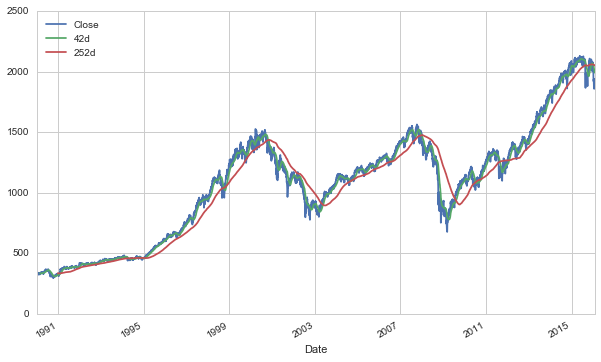

In [35]:
sp500[['Close', '{0}d'.format(short_ma), '{0}d'.format(long_ma)]].plot(figsize=(10,6))

In [36]:
SD = 50
allow_short = True 
p1 = short_ma
p2 = long_ma

sp500['Regime'] = np.where(sp500['{0}-{1}'.format(p1, long_ma)] > SD, 1, 0)

if allow_short:
    sp500['Regime'] = np.where(sp500['{0}-{1}'.format(p1, long_ma)] < -SD, -1, sp500['Regime'])

In [37]:
sp500['Regime'].value_counts()

 1    2898
 0    2749
-1     925
Name: Regime, dtype: int64

(-1.1, 1.1)

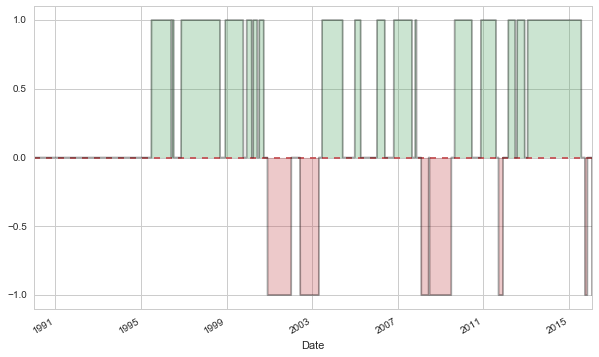

In [45]:
sp500['Regime'].plot(figsize=(10,6), kind='line', color='k', alpha=.4)
plt.hlines(0, sp500.index.min(), sp500.index.max(), colors='r', linestyles='dashed')
plt.fill_between(sp500.index, sp500['Regime'], where=(sp500['Regime']>0), color='g', alpha=.3)
plt.fill_between(sp500.index, sp500['Regime'], where=(sp500['Regime']<0), color='r', alpha=.3)
plt.ylim(-1.1, 1.1)

Now let's calculate the returns for our strategy by simply multiplying today's market returns by yesterday's market regime. The idea is that we would have take a position based on yesterday's regime after the close.

In [47]:
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

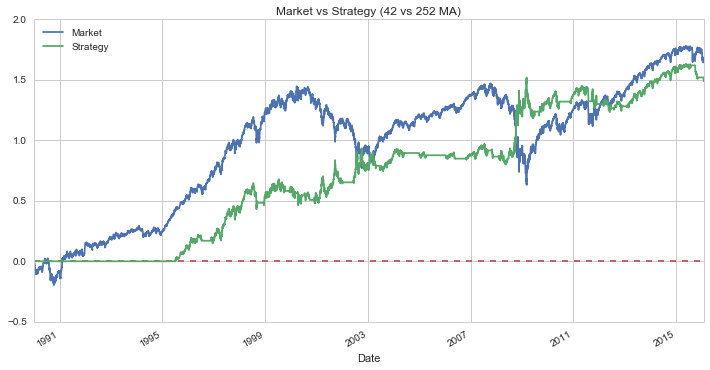

In [49]:
date_filter = (sp500.index >= '1990-01-01')# & (sp500.index < '2015-01-01')

sp500[date_filter][['Market', 'Strategy']].cumsum().plot(figsize=(12,6))
plt.hlines(0, sp500.index.min(), sp500.index.max(), colors='r', linestyles='dashed')
plt.title('Market vs Strategy ({0} vs {1} MA)'.format(p1, p2))
plt.show()